In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
dataset = pd.read_csv("Data/BTC-USD.csv")
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992


In [3]:
dataset.shape

(1827, 7)

In [4]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,15208.247358,15629.267253,14746.920288,15231.832471,15231.832471,2.092230e+10
std,16829.476707,17296.796539,16289.465757,16838.811505,16838.811505,2.122934e+10
min,775.177979,823.307007,755.755981,777.757019,777.757019,6.085170e+07
25%,5308.327637,5422.169434,5221.697753,5319.541504,5319.541504,4.474525e+09
50%,8585.262695,8744.828125,8313.340820,8595.740234,8595.740234,1.607165e+10
75%,13500.216309,13852.566406,12921.156250,13548.505860,13548.505860,3.260844e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [5]:
####### Preprocessing #######

In [6]:
#### Scaling ####
scaled_data = pd.DataFrame(dataset["Date"])
scaled_data["Close"] = dataset["Close"]
scaler = MinMaxScaler(copy=False)
scaled_data["Close"] = scaler.fit_transform(pd.DataFrame(scaled_data["Close"]))
scaled_data

,Date,Close
0,2016-12-21,0.000846
1,2016-12-22,0.001299
2,2016-12-23,0.002159
3,2016-12-24,0.001813
4,2016-12-25,0.001773
...,...,...
1822,2021-12-17,0.680117
1823,2021-12-18,0.689799
1824,2021-12-19,0.687676
1825,2021-12-20,0.690270


In [7]:
scaled_data["Date"] = pd.to_datetime(scaled_data['Date'])
scaled_data.set_index('Date')
X = (scaled_data.index -  scaled_data.index[0]).values.reshape(-1, 1)
X = X + 1
y = scaled_data["Close"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [8]:
####### Linear Regression #######

In [9]:
#### Training ####
linReg = LinearRegression()
linReg.fit(X_train, y_train)
y_pred_lin = linReg.predict(X_test)

In [10]:
#### Testing ####
print("Coefficients: \n", linReg.coef_)
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_lin))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lin))

Coefficients: 
 [[6.91533058e-05]]
Coefficient of determination: -1.76
Mean squared error: 0.21


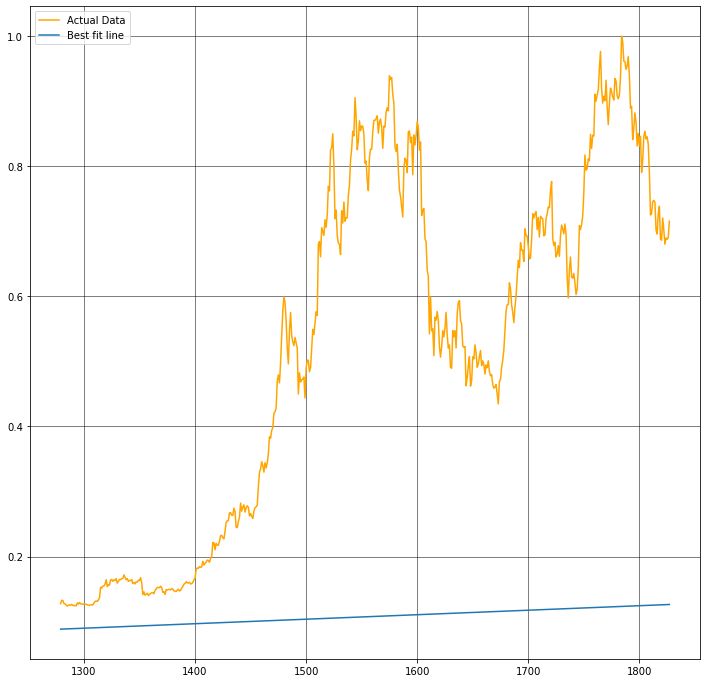

In [11]:
#### Plotting ####
plt.subplots(1, figsize=(12, 12))
plt.plot(X_test, y_test, '-', color='orange', label='Actual Data')
plt.plot(X_test, linReg.coef_ * X_test, label='Best fit line')
plt.grid(color='#000000', linestyle='-', linewidth=0.5)
plt.legend(loc="upper left")

In [12]:
####### Logistic Regression #######

In [13]:
scaled_data_log = scaled_data
scaled_data_log["Change"] = scaled_data.Close.gt(scaled_data.Close.shift())
scaled_data_log["Change"] = np.where(scaled_data_log["Change"] == False, 0, 1)
scaled_data_log

,Date,Close,Change
0,2016-12-21,0.000846,0
1,2016-12-22,0.001299,1
2,2016-12-23,0.002159,1
3,2016-12-24,0.001813,0
4,2016-12-25,0.001773,0
...,...,...,...
1822,2021-12-17,0.680117,0
1823,2021-12-18,0.689799,1
1824,2021-12-19,0.687676,0
1825,2021-12-20,0.690270,1


In [14]:
X = scaled_data_log
X = X.drop(["Change"], axis=1)
X = (scaled_data_log.index -  scaled_data_log.index[0]).values.reshape(-1, 1)
y = scaled_data_log["Change"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [16]:
#### Training ####
logReg = LogisticRegression()
logReg.fit(X_train, y_train)
y_pred_log = logReg.predict(X_test)

In [17]:
#### Testing ####
print("Coefficients: \n", logReg.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_log))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_log))

Coefficients: 
 [[-0.00041842]]
Mean squared error: 0.54
Coefficient of determination: -1.19


In [ ]:
#### Plotting ####
